In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets
import torch.utils.data
import PIL.Image

from torchvision import transforms
import torchvision.transforms.functional as F



import matplotlib as mpl


In [2]:
class Resize_with_pad:
    def __init__(self, w=1024, h=768, interpolation=transforms.InterpolationMode.BILINEAR):
        self.w = w
        self.h = h

    def __call__(self, image):

        w_1, h_1 = image.size
        ratio_f = self.w / self.h
        ratio_1 = w_1 / h_1


        # check if the original and final aspect ratios are the same within a margin
        if round(ratio_1, 2) != round(ratio_f, 2):

            # padding to preserve aspect ratio
            hp = int(w_1/ratio_f - h_1)
            wp = int(ratio_f * h_1 - w_1)
            if hp > 0 and wp < 0:
                hp = hp // 2
                image = F.pad(image, (0, hp, 0, hp), 0, "constant")
                return F.resize(image, [self.h, self.w])

            elif hp < 0 and wp > 0:
                wp = wp // 2
                image = F.pad(image, (wp, 0, wp, 0), 0, "constant")
                return F.resize(image, [self.h, self.w])

        else:
            return F.resize(image, [self.h, self.w])
torch
import torch.hub

In [3]:
classnames = {
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'potted plant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tv/monitor'
}
CLASS_MAX=20

In [4]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=CLASS_MAX  
    +1, init_features=32, pretrained=False)

Using cache found in /home/akors/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [5]:
dogunet = torch.load("dogunet_home.pth")

In [6]:
rwp = Resize_with_pad(256,256)

In [7]:
transform = transforms.Compose([
    Resize_with_pad(256,256),
    transforms.ToTensor(),
])

In [8]:
target_transform = transforms.Compose([
    Resize_with_pad(256,256, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

In [9]:
import os
download_ds = not os.path.exists('./data/VOCdevkit/')

In [10]:
ds_train = torchvision.datasets.VOCSegmentation(root="./data/", year="2012", image_set="train", download=download_ds, transform=transform, target_transform=target_transform)
#ds_val = torchvision.datasets.VOCSegmentation(root="./data/", year="2012", image_set="val", download=download_ds, transform=transform, target_transform=target_transform)

In [11]:
len(ds_train)

1464

In [12]:
img, mask = ds_train[2]

In [13]:
def show_img_tensor(img):
    plt.imshow(img.permute(1, 2, 0).numpy())

In [14]:
def show_pred_tensor(pred):
    pred = torch.argmax(pred.squeeze(0), dim=0)
    plt.imshow(pred.permute(0, 1).numpy())

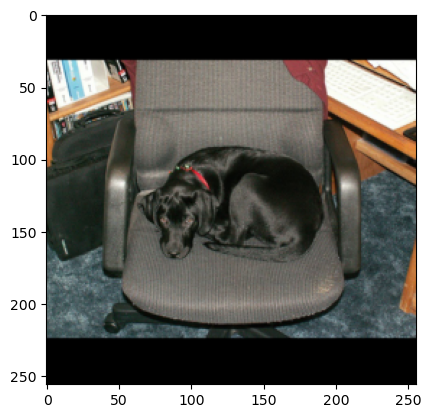

In [15]:
plt.imshow(img.permute(1, 2, 0).numpy())

In [16]:
img.shape

torch.Size([3, 256, 256])

In [17]:
pred = model(img.unsqueeze(0))

In [18]:
pred.shape

torch.Size([1, 21, 256, 256])

In [19]:
pred.squeeze(0).shape

torch.Size([21, 256, 256])

In [20]:
pred_amax = torch.argmax(pred.squeeze(0), dim=0)

In [21]:
pred_amax.shape

torch.Size([256, 256])

In [22]:
uniques, counts = torch.unique(pred_amax, return_counts=True)

In [23]:
uniques

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20])

In [24]:
counts

tensor([   60,    13,  4901,  2214,  2086, 10394,     2,   155,   167,  5141,
         2370,   685,   457,  5297,   452,     3, 11140,   551,   190, 19074,
          184])

In [25]:
count_sorted_idx = torch.argsort(counts, descending=True)

In [26]:
count_sorted_idx

tensor([19, 16,  5, 13,  9,  2, 10,  3,  4, 11, 17, 12, 14, 18, 20,  8,  7,  0,
         1, 15,  6])

In [27]:
counts[count_sorted_idx[0]]

tensor(19074)

In [28]:
classnames[uniques[count_sorted_idx[0]].item()]

'train'

In [29]:
most_pixel_class = torch.mode(pred_amax.flatten(), 0)[0]

In [30]:
torch.mode(pred_amax.flatten(), dim=0)

torch.return_types.mode(
values=tensor(19),
indices=tensor(39541))

In [31]:
most_pixel_class

tensor(19)

In [32]:
classnames[most_pixel_class.item()]

'train'

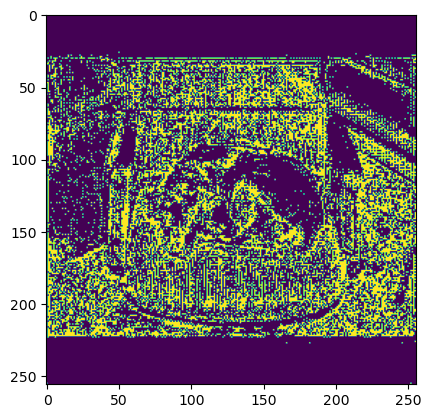

In [33]:
pred_img = (pred_amax == most_pixel_class).to(dtype=torch.int8)
plt.imshow(pred_img.permute(0, 1).numpy())

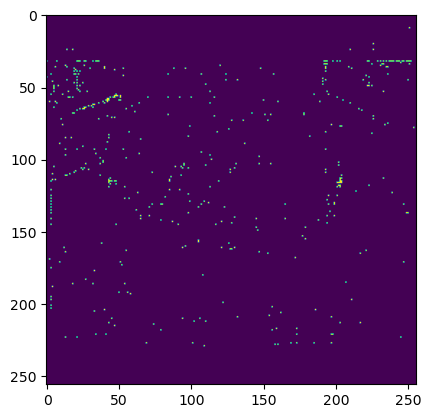

In [34]:
pred_img = (pred_amax == 12).to(dtype=torch.int8)
plt.imshow(pred_img.permute(0, 1).numpy())

In [35]:
mask = torch.where(mask <= CLASS_MAX, mask, 0).to(dtype=torch.long)

In [36]:
target_most_pixel_class = torch.mode(mask.flatten(), 0)[0]

In [37]:
target_most_pixel_class

tensor(0)

In [38]:
mask.shape

torch.Size([1, 256, 256])

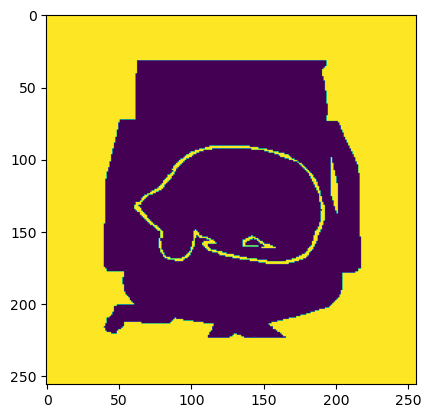

In [39]:
mask_img = (mask.squeeze(0) == target_most_pixel_class).to(dtype=torch.int8)
plt.imshow(mask_img.permute(0, 1).numpy())

In [40]:
import matplotlib
from typing import Optional

In [41]:
def imshow_tensor(img: torch.Tensor, ax: Optional[matplotlib.axes.Axes]=None):
    img = img.permute(1, 2, 0).numpy()
    if ax is None:
        ax = matplotlib.pyplot
    return ax.imshow(img)

In [42]:
img.shape

torch.Size([3, 256, 256])

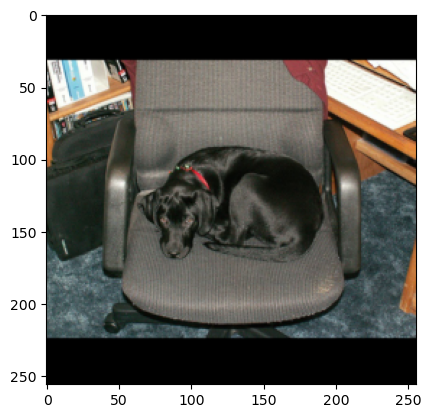

In [43]:
imshow_tensor(img)

In [44]:
def imshow_mask_tensor(mask: torch.Tensor, ax: Optional[matplotlib.axes.Axes]=None):
    mask = mask.permute(0, 1).numpy()
    if ax is None:
        ax = matplotlib.pyplot
    return ax.imshow(mask, cmap='tab20', interpolation_stage='rgba')

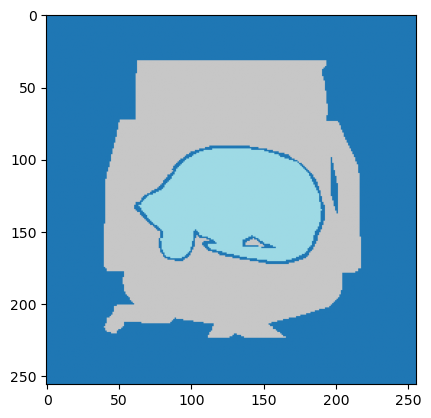

In [45]:
imshow_mask_tensor(mask.squeeze(0))

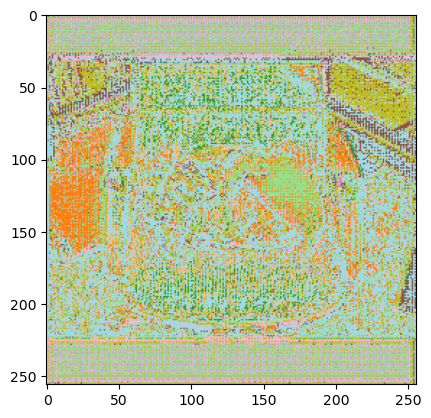

In [46]:
imshow_mask_tensor(pred_amax)

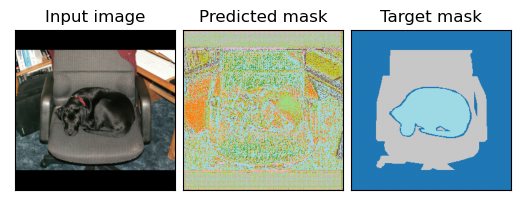

In [55]:
fig, axs = plt.subplots(1,3)

imshow_tensor(img, ax=axs[0])
axs[0].set_title("Input image")
imshow_mask_tensor(pred_amax, ax=axs[1])
axs[1].set_title("Predicted mask")
imshow_mask_tensor(mask.squeeze(0), ax=axs[2])
axs[2].set_title("Target mask")

# Adjust the spacing between the subplots using the figure
fig.subplots_adjust(wspace=0.05)

# Remove the ticks on the subplots
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [70]:
def plot_prediction_comparison(img: torch.Tensor, prediction_mask: torch.Tensor, target_mask: torch.Tensor):
    fig, axs = plt.subplots(1,3, gridspec_kw={'wspace': 0.05})

    imshow_tensor(img, ax=axs[0])
    axs[0].set_title("Input image")
    imshow_mask_tensor(prediction_mask, ax=axs[1])
    axs[1].set_title("Predicted mask")
    imshow_mask_tensor(target_mask, ax=axs[2])
    axs[2].set_title("Target mask")


    # Remove the ticks on the subplots
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    
    return fig

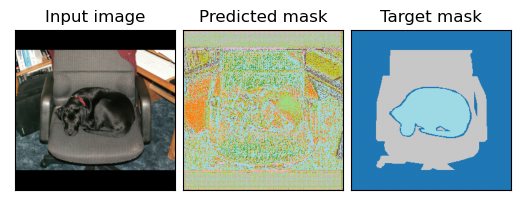

In [71]:
comparison_fig = plot_prediction_comparison(img, pred_amax, mask.squeeze(0))

In [69]:
comparison_fig.savefig()

AttributeError: 'tuple' object has no attribute 'savefig'

In [72]:
import visualize

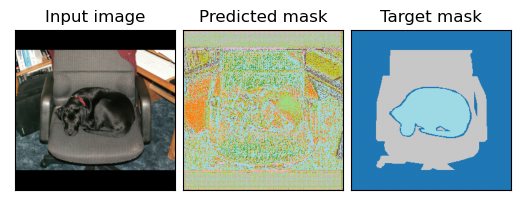

In [73]:
comp_fig = visualize.plot_prediction_comparison(img, pred_amax, mask.squeeze(0))